# Bias hardening and Shear in polarization

In [1]:
# imports
from polarization_stuff import *
import string

/home/noah/Berkeley/LensQuEst-1/basic_functions.py:98: RuntimeWarning: divide by zero encountered in true_divide
  try: return x/y
/home/noah/Berkeley/LensQuEst-1/cmb.py:127: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:135: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:149: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl


In [2]:
## Compute the noise curves in parallel
'''
import time
ti = time.time()

if __name__ == '__main__':
    pool = mp.Pool(mp.cpu_count())
    xxx = [27] 
    results = pool.map(save_noise_levels, xxx)

tf = time.time()
print((tf-ti)/60,'minutes')
'''

print('skipping this')

skipping this


In [3]:
tsz_profile = np.array([[0, 0.016160896130346235],
[39.32906813972806, 0.016160896130346235],
[52.24703795685751, 0.016160896130346235],
[59.00993144989722, 0.015916496945010187],
[67.32770836072729, 0.0154887983706721],
[76.04265448169258, 0.015000000000000003],
[92.2056872654036, 0.014419551934826885],
[108.45318002148963, 0.014022403258655806],
[120.03147810940575, 0.013564154786150716],
[131.50514100487536, 0.013105906313645624],
[150.0415195199824, 0.012617107942973525],
[164.3838057469932, 0.01218940936863544],
[181.93317316422946, 0.011761710794297353],
[203.4089434781318, 0.011150712830957232],
[220.60346765014833, 0.01069246435845214],
[246.64395998756476, 0.010203665987780042],
[267.4932179374444, 0.009684317718940938],
[299.0686739636277, 0.009073319755600816],
[348.21720097215655, 0.008523421588594706],
[397.30034550451853, 0.008004073319755603],
[453.30203131071477, 0.007362525458248472],
[517.1974651305281, 0.006782077393075358],
[584.1438702920249, 0.0063543788187372715],
[694.0802577795791, 0.005651731160896132],
[841.6085369734457, 0.005040733197556008],
[999.999999999999, 0.004460285132382894],
[1224.9143623942925, 0.003849287169042769],
[1531.1651169368401, 0.003329938900203666],
[1953.2098181672693, 0.0027189409368635446],
[2516.9874914911766, 0.0021690427698574342],
[3276.562844946423, 0.0016496945010183311],
[4222.315298186072, 0.0012525458248472503],
[6021.929721718364, 0.0008248472505091656]])

profile_bh_tsz = interp1d(tsz_profile[:,0],tsz_profile[:,1]/tsz_profile[:,1][0])

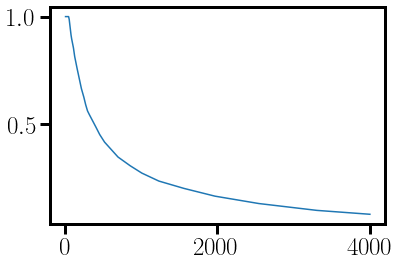

In [4]:
ells = np.linspace(10,4000,500)

plt.plot(ells,profile_bh_tsz(ells))

In [5]:
def get_angular_averaged_FBH(ells=ells,profile_bh = lambda l: 0*l+1):

    def FTT_L0(l,theta):
        dCdlnl = (cmb.flensedTT(l+1) - cmb.flensedTT(l)) / (np.log(l+1) - np.log(l))
        result = 2*cmb.flensedTT(l) + dCdlnl + dCdlnl * np.cos(2*theta)
        return result / 2 / Ctt_(l)**2
    
    def integrand(l):
        dCdlnl = (cmb.flensedTT(l+1) - cmb.flensedTT(l)) / (np.log(l+1) - np.log(l))
        return l * (2*cmb.flensedTT(l) + dCdlnl) * profile_bh(l)**2 / (2*np.pi) / 2 / Ctt_(l)**2
    integrand_arr = np.array([integrand(l) for l in ells])
    AAA = scipy.integrate.simps(integrand_arr * (ells <=3500) * (ells >=10),x=ells)
    
    def GTT_L0(l,theta):
        return profile_bh(l)**2/2/Ctt_(l)**2

    def integrand(l):
        return l * GTT_L0(l,0.) * profile_bh(l)**2 / (2*np.pi)
    integrand_arr = np.array([integrand(l) for l in ells])
    BBB = scipy.integrate.simps(integrand_arr * (ells <=3500) * (ells >=10),x=ells)

    # bias hardened weights in the squeezed limit
    def FBH(l,theta):
        if profile_bh(l)<0: return FTT_L0(l,theta)
        return FTT_L0(l,theta) - AAA*GTT_L0(l,theta)/BBB
    
    # norm for bias hardened estimator
    def MC_integrand3(x):
        l,theta = x[0],x[1]
        return l * FBH(l,theta) * FTT_L0(l,theta) * 2 * Ctt_(l)**2 / (2*np.pi)**2
    integ = vegas.Integrator([[10, 3500], [0., 2.*np.pi]])
    integral = integ(MC_integrand3, nitn=20, neval=100)
    norm_BH = 1/integral.mean

    # bias hardened weights integrated over all angles
    def angular_avg_FBH(l):
        dCdlnl = (cmb.flensedTT(l+1) - cmb.flensedTT(l)) / (np.log(l+1) - np.log(l))
        result = 2*cmb.flensedTT(l) + dCdlnl
        result /=  2 * Ctt_(l)**2
        if profile_bh(l)<0: return 2*np.pi*result
        result -= AAA*GTT_L0(l,0.)/BBB
        return 2*np.pi*result
    
    return norm_BH,np.array([norm_BH*l*angular_avg_FBH(l) for l in ells])

In [6]:
profile_bh = lambda l: 0*l+1

def FTT_L0(l,theta):
    dCdlnl = (cmb.flensedTT(l+1) - cmb.flensedTT(l)) / (np.log(l+1) - np.log(l))
    result = 2*cmb.flensedTT(l) + dCdlnl + dCdlnl * np.cos(2*theta)
    return result / 2 / Ctt_(l)**2

def integrand(l):
    dCdlnl = (cmb.flensedTT(l+1) - cmb.flensedTT(l)) / (np.log(l+1) - np.log(l))
    return l * (2*cmb.flensedTT(l) + dCdlnl) * profile_bh(l)**2 / (2*np.pi) / 2 / Ctt_(l)**2
integrand_arr = np.array([integrand(l) for l in ells])
AAA = scipy.integrate.simps(integrand_arr * (ells <=3500) * (ells >=10),x=ells)

def GTT_L0(l,theta):
    return profile_bh(l)**2/2/Ctt_(l)**2

def integrand(l):
    return l * GTT_L0(l,0.) * profile_bh(l)**2 / (2*np.pi)
integrand_arr = np.array([integrand(l) for l in ells])
BBB = scipy.integrate.simps(integrand_arr * (ells <=3500) * (ells >=10),x=ells)

# bias hardened weights in the squeezed limit
def FBH(l,theta):
    if profile_bh(l)<0: return FTT_L0(l,theta)
    return FTT_L0(l,theta) - AAA*GTT_L0(l,theta)/BBB

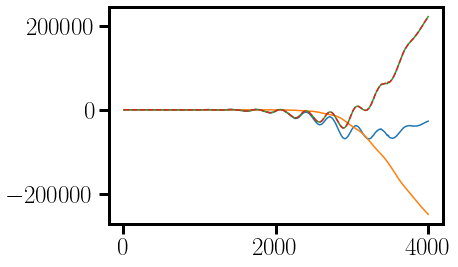

In [7]:
plt.plot(ells,[FTT_L0(l,np.pi/4) for l in ells])
plt.plot(ells,[AAA*GTT_L0(l,np.pi/4)/BBB for l in ells])
plt.plot(ells,[FTT_L0(l,np.pi/4)-AAA*GTT_L0(l,np.pi/4)/BBB for l in ells])
plt.plot(ells,[FBH(l,np.pi/4) for l in ells],ls='--')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


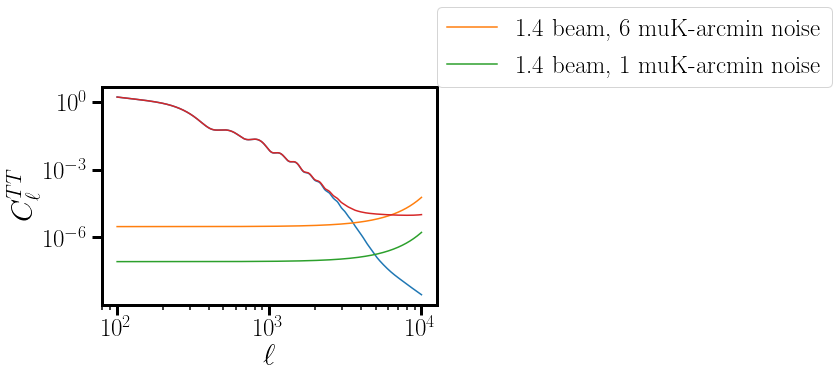

In [8]:
Ells = np.logspace(2,4,1000)

plt.loglog(Ells,[cmb.flensedTT(l) for l in Ells])
plt.loglog(Ells,[cmb.fdetectorNoise(l)*36 for l in Ells],label='1.4 beam, 6 muK-arcmin noise')
plt.loglog(Ells,[cmb.fdetectorNoise(l) for l in Ells],label='1.4 beam, 1 muK-arcmin noise')

plt.loglog(Ells,[cmb.ftotalTT(l) for l in Ells])

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C^{TT}_\ell$')
plt.legend(loc=(1,1))

In [9]:
def response(ells,angular_avg_PSH,profile= lambda l: 1+l*0):
    integrand = angular_avg_PSH * profile(ells)**2 / (2*np.pi)**2 
    return scipy.integrate.simps(integrand * (ells <3500) * (ells >=10),x=ells)

In [10]:
norm_PSH,angular_avg_PSH = get_angular_averaged_FBH()

In [11]:
norm_QE,angular_avg_QE = get_angular_averaged_FBH(profile_bh = lambda l: l*0-1)

In [12]:
norm_PH,angular_avg_PH = get_angular_averaged_FBH(profile_bh=profile_bh_tsz)

In [13]:
norm_G1,angular_avg_G1 = get_angular_averaged_FBH(profile_bh=lambda l: np.exp(-(2* np.pi * l/10800 )**2 / 8 / np.log(2)) )

In [14]:
norm_G2,angular_avg_G2 = get_angular_averaged_FBH(profile_bh=lambda l: np.exp(-(1* np.pi * l/10800 )**2 / 8 / np.log(2)) )

In [15]:
norm_G3,angular_avg_G3 = get_angular_averaged_FBH(profile_bh=lambda l: np.exp(-(0.5* np.pi * l/10800 )**2 / 8 / np.log(2)) )

In [16]:
def response_ratio(sigma):
    profile = lambda l: np.exp(-(l*sigma)**2)
    return np.abs(response(ells,angular_avg_PSH,profile=profile))

def response_ratio2(sigma):
    profile = lambda l: np.exp(-(l*sigma)**2)
    return np.abs(response(ells,angular_avg_PH,profile=profile))

def response_ratio3(sigma):
    profile = lambda l: np.exp(-(l*sigma)**2)
    return np.abs(response(ells,angular_avg_QE,profile=profile))

def response_ratio4(sigma):
    profile = lambda l: np.exp(-(l*sigma)**2)
    return np.abs(response(ells,angular_avg_G1,profile=profile))

def response_ratio5(sigma):
    profile = lambda l: np.exp(-(l*sigma)**2)
    return np.abs(response(ells,angular_avg_G2,profile=profile))

def response_ratio6(sigma):
    profile = lambda l: np.exp(-(l*sigma)**2)
    return np.abs(response(ells,angular_avg_G3,profile=profile))

In [17]:
sigmas = np.logspace(-5,-3,1000)
res = np.array([response_ratio(s) for s in sigmas])
res2 = np.array([response_ratio2(s) for s in sigmas])
res3 = np.array([response_ratio3(s) for s in sigmas])
res4 = np.array([response_ratio4(s) for s in sigmas])
res5 = np.array([response_ratio5(s) for s in sigmas])
res6 = np.array([response_ratio6(s) for s in sigmas])

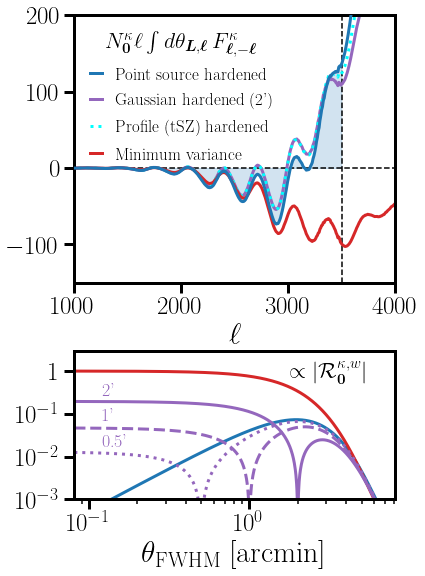

In [34]:
fig,ax = plt.subplots(2,1,figsize=(6,8),gridspec_kw={'height_ratios': [1.8, 1]})
fig.tight_layout()

ax[0].axvline(x=3500,c='k',ls='--',lw=1.5)
ax[0].axhline(y=0,c='k',ls='--',lw=1.5)

ax[0].plot(ells,angular_avg_PSH,c='C0',lw=3,label=r'Point source hardened',zorder=3)
ax[0].plot(ells,angular_avg_G1,c='C4',lw=3,label="Gaussian hardened (2')")
ax[0].plot(ells,angular_avg_PH,c='cyan',ls='dotted',lw=3,label='Profile (tSZ) hardened')
ax[0].plot(ells,angular_avg_QE,c='C3',lw=3,label=r'Minimum variance')

I = np.where(ells < 3500)
ax[0].fill_between(ells[I],angular_avg_PSH[I],np.zeros(angular_avg_PSH[I].shape),color='C0',alpha=0.2)

ax[0].set_ylim(-150,200)
ax[0].set_xlim(1000,4000)
ax[0].set_xlabel(r'$\ell$')
ax[0].legend(loc='upper left',frameon=False,handlelength=0.7,ncol=1,fontsize=17,title=r'$N^\kappa_{\boldsymbol{0}}\ell\int d\theta_{\boldsymbol{L},\boldsymbol{\ell}}\, F^\kappa_{\boldsymbol{\ell},-\boldsymbol{\ell}}$')

#######################################################

ax[1].loglog(sigmas*np.sqrt(8*np.log(2))*10800/np.pi,res/res3[0],lw=3,c='C0')

ax[1].loglog(sigmas*np.sqrt(8*np.log(2))*10800/np.pi,res3/res3[0],lw=3,c='C3')

#ax[1].loglog(sigmas*np.sqrt(8*np.log(2))*10800/np.pi,res2,lw=3,c='cyan')

ax[1].loglog(sigmas*np.sqrt(8*np.log(2))*10800/np.pi,res4/res3[0],lw=3,c='C4')
ax[1].loglog(sigmas*np.sqrt(8*np.log(2))*10800/np.pi,res5/res3[0],lw=3,ls='--',c='C4')
ax[1].loglog(sigmas*np.sqrt(8*np.log(2))*10800/np.pi,res6/res3[0],lw=3,ls='dotted',c='C4')

plt.text(0.12,460/res3[0],string.capwords("2'"),fontsize=18,color='C4')
plt.text(0.12,120/res3[0],string.capwords("1'"),fontsize=18,color='C4')
plt.text(0.12,30/res3[0],string.capwords("0.5'"),fontsize=18,color='C4')

ax[1].text(1.8,1200/res3[0],r'$\propto |\mathcal{R}^{\kappa,w}_{\boldsymbol{0}}|$')
ax[1].set_ylim(1e-3,3)
ax[1].set_xlim(1e-5*np.sqrt(8*np.log(2))*10800/np.pi,1e-3*np.sqrt(8*np.log(2))*10800/np.pi)
ax[1].set_xlabel(r'$\theta_\text{FWHM}$ [arcmin]')
ax[1].set_yticks([1e-3,1e-2,1e-1,1])
ax[1].set_yticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$1$'])

plt.savefig('intuition.pdf',bbox_inches='tight')

In [6]:
LL_QE_TT,QE_TT = np.genfromtxt('QE_TT.txt')
LL_QE_TE,QE_TE = np.genfromtxt('QE_TE.txt')
LL_QE_TB,QE_TB = np.genfromtxt('QE_TB.txt')
LL_QE_EE,QE_EE = np.genfromtxt('QE_EE.txt')
LL_QE_EB,QE_EB = np.genfromtxt('QE_EB.txt')

#LL,QE_sym_TE = np.genfromtxt('QE_sym_TE.txt')

LL_BH_TT,BH_TT = np.genfromtxt('BH_TT.txt')
LL_BH_TE,BH_TE = np.genfromtxt('BH_TE.txt')
LL_BH_TB,BH_TB = np.genfromtxt('BH_TB.txt')
LL_BH_EE,BH_EE = np.genfromtxt('BH_EE.txt')
LL_BH_EB,BH_EB = np.genfromtxt('BH_EB.txt')

LL_Shear_TT,Shear_TT = np.genfromtxt('Shear_TT.txt')
LL_Shear_TE,Shear_TE = np.genfromtxt('Shear_TE.txt')
LL_Shear_TB,Shear_TB = np.genfromtxt('Shear_TB.txt')
LL_Shear_EE,Shear_EE = np.genfromtxt('Shear_EE.txt')
LL_Shear_EB,Shear_EB = np.genfromtxt('Shear_EB.txt')

LL_GMV, GMV = np.genfromtxt('GMV.txt')
LL_BH_GMV, BH_GMV = np.genfromtxt('BH_GMV.txt')
LL_GMV_Shear, GMV_Shear = np.genfromtxt('GMV_Shear.txt')

LL_TTTE,TTTE = np.genfromtxt('TTTE.txt')
LL_TTEE,TTEE = np.genfromtxt('TTEE.txt')
LL_TEEE,TEEE = np.genfromtxt('TEEE.txt')
LL_TBEB,TBEB = np.genfromtxt('TBEB.txt')

LL_TTTE_BH,TTTE_BH = np.genfromtxt('TTTE_BH.txt')
LL_TTEE_BH,TTEE_BH = np.genfromtxt('TTEE_BH.txt')
LL_TEEE_BH,TEEE_BH = np.genfromtxt('TEEE_BH.txt')
LL_TBEB_BH,TBEB_BH = np.genfromtxt('TBEB_BH.txt')

In [7]:
# Noise for MV lin comb of 
# MV estimators


MV_TT = interp1d(LL_QE_TT,QE_TT)(LL_TTTE)
MV_TE = interp1d(LL_QE_TE,QE_TE)(LL_TTTE)
MV_TB = interp1d(LL_QE_TB,QE_TB)(LL_TTTE)
MV_EE = interp1d(LL_QE_EE,QE_EE)(LL_TTTE)
MV_EB = interp1d(LL_QE_EB,QE_EB)(LL_TTTE)

O = np.zeros(LL_TTTE.shape)

N_XYMN = np.array([[MV_TT,   TTTE ,  O    ,  TTEE ,   O    ],
                   [TTTE ,   MV_TE,  O    ,  TEEE ,   O    ],
                   [O    ,   O    ,  MV_TB,  O    ,   TBEB ],
                   [TTEE ,   TEEE ,  O    ,  MV_EE,   O    ],
                   [O    ,   O    ,  TBEB ,  O    ,   MV_EB]])


Ninv_XYMN = np.array([np.linalg.inv(N_XYMN[:,:,i]) for i in range(len(MV_TT))])
ONE = np.ones(5)

LMV = 1/ np.array([np.dot(np.dot(ONE,Ninv_XYMN[i,:,:]),ONE) for i in range(len(MV_TT))])

In [8]:
# Noise for MV lin comb of 
# PSH estimators

PSH_TT = interp1d(LL_BH_TT,BH_TT)(LL_TTTE_BH)
PSH_TE = interp1d(LL_BH_TE,BH_TE)(LL_TTTE_BH)
PSH_TB = interp1d(LL_BH_TB,BH_TB)(LL_TTTE_BH)
PSH_EE = interp1d(LL_BH_EE,BH_EE)(LL_TTTE_BH)
PSH_EB = interp1d(LL_BH_EB,BH_EB)(LL_TTTE_BH)

O = np.zeros(LL_TTTE_BH.shape)

N_XYMN_BH = np.array([[PSH_TT  ,   TTTE_BH ,  O       ,  TTEE_BH ,   O      ],
                      [TTTE_BH ,   PSH_TE  ,  O       ,  TEEE_BH ,   O      ],
                      [O       ,   O       ,  PSH_TB  ,  O       ,   TBEB_BH],
                      [TTEE_BH ,   TEEE_BH ,  O       ,  PSH_EE  ,   O      ],
                      [O       ,   O       ,  TBEB_BH ,  O       ,   PSH_EB ]])


Ninv_XYMN_BH = np.array([np.linalg.inv(N_XYMN_BH[:,:,i]) for i in range(len(PSH_TT))])
ONE = np.ones(5)

LMV_BH = 1/ np.array([np.dot(np.dot(ONE,Ninv_XYMN_BH[i,:,:]),ONE) for i in range(len(PSH_TT))])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


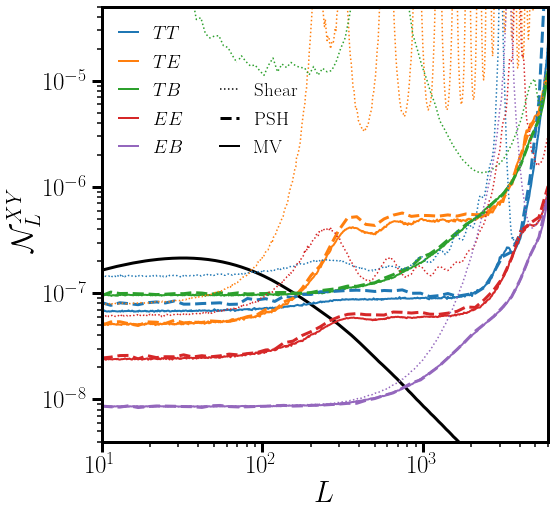

In [3]:
plt.figure(figsize=(8,8))

plt.loglog(LL_QE_TT,p2d_cmblens.fPinterp(LL_QE_TT),c='k',lw=3)

plt.loglog(LL_QE_TT,QE_TT,lw=2,c='C0',label=r'$TT$')
plt.loglog(LL_QE_TE,QE_TE,lw=2,c='C1',label=r'$TE$')
plt.loglog(LL_QE_TB,QE_TB,lw=2,c='C2',label=r'$TB$')
plt.loglog(LL_QE_EE,QE_EE,lw=2,c='C3',label=r'$EE$')
plt.loglog(LL_QE_EB,QE_EB,lw=2,c='C4',label=r'$EB$')

plt.loglog(LL_BH_TT,BH_TT,lw=3,c='C0',ls='--')
plt.loglog(LL_BH_TE,BH_TE,lw=3,c='C1',ls='--')
plt.loglog(LL_BH_TB,BH_TB,lw=3,c='C2',ls='--')
plt.loglog(LL_BH_EE,BH_EE,lw=3,c='C3',ls='--')
plt.loglog(LL_BH_EB,BH_EB,lw=3,c='C4',ls='--')

plt.loglog(LL_Shear_TT,Shear_TT,lw=1.5,c='C0',ls='dotted')
plt.loglog(LL_Shear_TE,Shear_TE,lw=1.5,c='C1',ls='dotted')
plt.loglog(LL_Shear_TB,Shear_TB,lw=1.5,c='C2',ls='dotted')
plt.loglog(LL_Shear_EE,Shear_EE,lw=1.5,c='C3',ls='dotted')
plt.loglog(LL_Shear_EB,Shear_EB,lw=1.5,c='C4',ls='dotted')

plt.loglog([],[],lw=3,c='white',ls='dotted',label=r'$ $')
plt.loglog([],[],lw=3,c='white',ls='dotted',label=r'$ $')
plt.loglog([],[],lw=1.5,c='k',ls='dotted',label=r'Shear')
plt.loglog([],[],lw=3,c='k',ls='--',label=r'PSH')
plt.loglog([],[],lw=2,c='k',label=r'MV')


plt.legend(loc=0,frameon=False,handlelength=1,ncol=2,fontsize=19)
plt.xlabel(r'$L$')
plt.ylabel(r'$\mathcal{N}^{XY}_L$')
plt.ylim(4e-9,5e-5)
plt.xlim(10,6000)
plt.savefig('noise_curves.pdf',bbox_inches='tight')

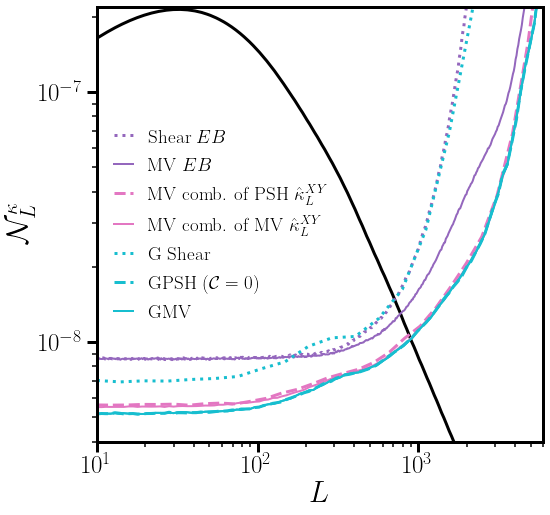

In [16]:
plt.figure(figsize=(8,8))


LLL = np.logspace(1,4,1000)
plt.loglog(LLL,p2d_cmblens.fPinterp(LLL),c='k',lw=3)

plt.loglog(LL_Shear_EB,Shear_EB,lw=3,c='C4',ls='dotted',label=r'Shear $EB$')
plt.loglog(LL_QE_EB,QE_EB,lw=2,c='C4',label=r'MV $EB$')
plt.loglog(LL_TTTE_BH,LMV_BH,c='C6',ls='--',lw=3,label=r'MV comb. of PSH $\hat{\kappa}^{XY}_L$')
plt.loglog(LL_TTTE,LMV,c='C6',lw=2,label=r'MV comb. of MV $\hat{\kappa}^{XY}_L$')

plt.loglog(LL_GMV_Shear,GMV_Shear,c='C9',ls='dotted',lw=3,label=r'G Shear')
plt.loglog(LL_BH_GMV,BH_GMV,c='C9',ls='--',lw=3,label=r'GPSH $(\mathcal{C} = 0)$')
plt.loglog(LL_GMV,GMV,c='C9',lw=2)
plt.loglog(LL_GMV,GMV,c='C9',lw=2,label=r'GMV')

plt.legend(loc=0,frameon=False,handlelength=1,ncol=1,fontsize=19)
plt.xlabel(r'$L$')
plt.ylabel(r'$\mathcal{N}^\kappa_L$')
plt.ylim(4e-9,2.2e-7)
plt.xlim(10,6000)
plt.savefig('noise_curves_combined.pdf',bbox_inches='tight')

# Algebra time

This is what Wolfram tells me:

$$\sin\left(2\cos^{-1}(x)\right) = 2x\sqrt{1-x^2}$$


$$\cos\left(2\cos^{-1}(x)\right) = 2x^2-1$$


_______________________________________________________________________________
Here's an obvious relation:


$$\theta_{\ell,L-\ell} = \cos^{-1}\left(\frac{L \cos(\theta_{\ell,L}) - \ell}{ \sqrt{\ell^2+L^2 - 2\ell L
\cos(\theta_{\ell,L})}}\right)$$

$$\theta_{L,L-\ell} = \cos^{-1}\left(\frac{L - \ell \cos(\theta_{L,\ell})}{ \sqrt{\ell^2+L^2 - 2\ell L
\cos(\theta_{\ell,L})}}\right)$$

_______________________________________________________________________________
For clarity I'll define $\epsilon\equiv L/\ell$ and $\theta\equiv\theta_{\ell,L}$. After some work I find:

$$\sin(2\theta_{\ell,L-\ell}) = \frac{\epsilon^2 \sin(2\theta) - 2\epsilon\sin(\theta)}{1+\epsilon^2 - 2\epsilon
\cos(\theta)} 
 $$

$$\cos(2\theta_{\ell,L-\ell}) = \frac{\epsilon^2 \cos(2\theta) + 1 - 2 \epsilon\cos(\theta)}{1+\epsilon^2 - 2\epsilon
\cos(\theta)}$$

$$\sin(2\theta_{L,L-\ell}) = \frac{2\epsilon \sin(\theta) - \sin(2\theta)}{1+\epsilon^2 - 2\epsilon
\cos(\theta)} 
 $$
 
$$\cos(2\theta_{L,L-\ell}) = \frac{\epsilon^2  + \cos(2\theta) - 2 \epsilon\cos(\theta)}{1+\epsilon^2 - 2\epsilon
\cos(\theta)}$$

_______________________________________________________________________________
Taylor expanding gives


$$ \sin(2\theta_{\ell,L-\ell}) =  -2 x \sin (\theta )-x^2 \sin (2 \theta )-2 x^3 (\sin (\theta ) \cos (2 \theta ))-x^4 \sin
   (2 \theta ) (2 \cos (2 \theta )-1)+x^5 (\sin (3 \theta )-\sin (5 \theta ))+x^6 \sin (2
   \theta ) (2 \cos (2 \theta )-2 \cos (4 \theta )-1)+O\left(x^7\right)$$

In [2]:
# I'm double checking that I didn't fuck up my math

def theta2(L,l,theta):
    result = L*np.cos(theta)-l
    result /= np.sqrt(l**2 + L**2 - 2*l*L*np.cos(theta))
    return np.arccos(result)

def sin_math(L,l,theta):
    eps = L/l
    result = eps**2 * np.sin(2*theta) - 2*eps * np.sin(theta)
    result /= 1 + eps**2 - 2*eps*np.cos(theta)
    return result

def cos_math(L,l,theta):
    eps = L/l
    result = eps**2 * np.cos(2*theta) + 1 - 2*eps * np.cos(theta)
    result /= 1 + eps**2 - 2*eps*np.cos(theta)
    return result

L,l,theta = 300,3000,np.pi/3

np.sin(2*theta2(L,l,-theta))/sin_math(L,l,-theta)  ,  np.cos(2*theta2(L,l,theta))/cos_math(L,l,theta)

(-1.0000000000000087, 0.9999999999999997)

In [10]:
L,l,theta = 300,3000,3*np.pi/4

(np.sin(2*theta2(1e-6+ 0.002,l,theta)) - 2*np.sin(2*theta2(1e-6 + 0.001,l,theta)) +  np.sin(2*theta2(1e-6,l,theta)))/0.001**2

0.0009410223712418017